Las imágenes obtenidas suelen tener bordes de lineas negras en los contornos. Este no es un problema derivado del proceso de extracción de imágenes per sé sino un inconveniente debido al extractor de imágenes de Python que se ha empleado, añadiendo un marco en los contornos que no es deseado.

Este notebook se encarga de realizar un ligero preprocesamiento para eliminar los márcos introducidos, a la vez que obtener tamaños de imágenes que sean favorables para introducir a las redes neuronales, ya que durante el proceso de reconstruir una imagen se espera que el tamaño de este sea idealmente múltiplos de 2. De esta forma se puede garantizar que las entradas y las salidas coincidan en tamaño.

In [1]:
import pandas as pd
import numpy as np
import os

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [ ]:
original = './autoencoder_data/original/'
reduced = './autoencoder_data/downsampled/'

In [3]:
def visualize_images(directory):
    """
    Carga todas las imágenes PNG del directorio especificado.

    Args:
    - directory (str): Path al directorio que contiene las imágenes.

    Returns:
    - Lista de imágenes (list): Lista de las imágenmes cargadas.
    """
    # Initialize an empty list to store the images
    images = []
    
    # Check if the directory exists
    if not os.path.isdir(directory):
        print(f"The directory {directory} does not exist.")
        return images
    
    # List all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            try:
                # Load the image and append to the list
                img = Image.open(file_path)
                images.append(img)
            except IOError as e:
                print(f"Could not read image {filename}: {e}")

    return images

In [ ]:
originales_vis = visualize_images(original)
reducidas_vis = visualize_images(reduced)

In [ ]:
originales_vis[0]

In [4]:
def load_lidar_images(original_dir, downsampled_dir):
    """
    Carga las imágenes de la nube de puntos LiDAR de los directorios especificados para las imágenes originales y reducidas.
    La función asume que las imágenes están nombradas en el formato 'velodyne_XXXX.png' y están ordenadas numéricamente.
    
    Args:
    - original_dir (str): Directorio que contiene las imagenes originales.
    - downsampled_dir (str): Directorio que contiene las imagenes reducidas.
    
    Returns:
    - original images: Las imagenes originales de la nube de puntos.
    - downsampled images: Las imagenes reducidas de la nube de puntos.
    """
    original_list = []
    downsampled_list = []
    
    # Fetch all image filenames from the downsampled directory and sort them
    downsampled_images = sorted([f for f in os.listdir(downsampled_dir) if f.endswith('.png')])
    
    # Loop through each image in the sorted list of downsampled images
    for downsampled_image_filename in downsampled_images:
        # Construct the file path for the downsampled image
        downsampled_image_path = os.path.join(downsampled_dir, downsampled_image_filename)
        
        # Construct the file path for the corresponding original image
        original_image_filename = downsampled_image_filename  # Since filenames are the same across folders
        original_image_path = os.path.join(original_dir, original_image_filename)
        
        # Load the downsampled and original images using PIL and convert them to numpy arrays
        downsampled_image = Image.open(downsampled_image_path).convert('L')
        original_image = Image.open(original_image_path).convert('L')
        
        # Append the (original, downsampled) pair to the list, converting images to numpy arrays
        original_list.append(np.array(original_image, dtype=np.float32) / 255.0)
        downsampled_list.append(np.array(downsampled_image, dtype=np.float32) / 255.0)

    # Convert lists to numpy arrays
    original_array = np.stack(original_list, axis=0)
    downsampled_array = np.stack(downsampled_list, axis=0)
    
    return original_array, downsampled_array

In [ ]:
def process_images(source_directory, target_directory, top_crop, bottom_crop, left_crop, right_crop):
    """
    Procesa todas las imágenes en el directorio fuente especificado recortando un número fijo de píxeles
    desde la parte superior, inferior, izquierda y derecha y guarda las imágenes procesadas en el directorio de destino.

    Parameters:
    - source_directory (str): Path al directorio que contiene las imágenes originales.
    - target_directory (str): Path al directorio donde se guardarán las imágenes procesadas.
    - top_crop (int): Número de píxeles a recortar desde la parte superior de cada imagen.
    - bottom_crop (int): Número de píxeles a recortar desde la parte inferior de cada imagen.
    - left_crop (int): Número de píxeles a recortar desde la parte izquierda de cada imagen.
    - right_crop (int): Número de píxeles a recortar desde la parte derecha de cada imagen.
    """
    # Create the target directory if it does not exist
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    # Iterate over all files in the source directory
    for filename in os.listdir(source_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for common image file extensions
            file_path = os.path.join(source_directory, filename)
            img = Image.open(file_path)
            
            # Perform cropping
            new_top_index = top_crop
            new_bottom_index = img.size[1] - bottom_crop
            new_left_index = left_crop
            new_right_index = img.size[0] - right_crop
            cropped_img = img.crop((new_left_index, new_top_index, new_right_index, new_bottom_index))
            
            # Save the cropped image to the target directory
            cropped_img.save(os.path.join(target_directory, filename))

In [ ]:
original_data, downsample_data = load_lidar_images(original, reduced)

## Recortado de bordes de las imágenes de KITTI

In [4]:
source_dir = 'ruta de las imágenes originales'
target_dir = 'ruta de las imágenes recortadas'
process_images(source_dir, target_dir, 60, 85, 0, 0)

In [ ]:
source_dir = 'ruta de las imágenes reducidas'
target_dir = 'ruta de las imágenes recortadas'
process_images(source_dir, target_dir, 60, 85, 0, 0)

## Segmentación de partes de imágenes

In [11]:
def image_segmentation(source_directory, target_directory, num_segments):
    """
    Procesa todas las imágenes en el directorio fuente especificado dividiendo cada imagen en
    partes iguales horizontalmente y guarda las imágenes procesadas en el directorio de destino.

    Parameters:
    - source_directory (str): Path al directorio que contiene las imágenes originales.
    - target_directory (str): Path al directorio donde se guardarán las imágenes procesadas.

    El número de segmentos en los que se quiere dividir la imagen se puede especificar en el código
    """
    # Crear el directorio de destino si no existe
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    # Iterar sobre todos los archivos en el directorio
    for filename in os.listdir(source_directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Comprueba las extensiones de archivo de imagen comunes
            file_path = os.path.join(source_directory, filename)
            img = Image.open(file_path)
            
            # Obtener el ancho y alto de la imagen
            width, height = img.size
            part_width = width // num_segments
            
            # Separa la imagen en segmentos y guarda cada segmento en el directorio de destino
            for i in range(num_segments):
                left = i * part_width
                right = (i + 1) * part_width
                part_img = img.crop((left, 0, right, height))
                
                # Se guarda cada segmento con el nombre del archivo original seguido de un número de segmento
                base_name, ext = os.path.splitext(filename)
                new_filename = f"{base_name}_{i + 1}{ext}"
                part_img.save(os.path.join(target_directory, new_filename))


In [ ]:
# KITTI ORIGINAL DATA
source_dir = 'ruta a las imagenes originales'
target_dir = 'ruta a las imagenes recortadas'
image_segmentation(source_dir, target_dir, 3)

In [ ]:
# KITTI DOWNSAMPLED DATA
source_dir = 'ruta a las imagenes con canales reducidos'
target_dir = 'ruta a las imagenes procesados con canales reducidos'
image_segmentation(source_dir, target_dir, 3)

In [12]:
# ETSISI ORIGINAL DATA
source_dir = 'ruta a las imagenes originales'
target_dir = 'ruta a las imagenes procesados'
image_segmentation(source_dir, target_dir, 4)

In [13]:
# ETSISI DOWNSAMPLED DATA
source_dir = 'ruta a las imagenes con canales reducidos'
target_dir = 'ruta a las imagenes procesados con canales reducidos'
image_segmentation(source_dir, target_dir, 4)

## Imágenes con vista de pájaro 500x500

In [ ]:
original = 'ruta a las imágenes birdview originales'
reduced = 'ruta a las imágenes birdview reducidas'

In [ ]:
original_data, downsample_data = load_lidar_images(original, reduced)
originales_vis = visualize_images(original)
reducidas_vis = visualize_images(reduced)

In [ ]:
img = originales_vis[0]

In [ ]:
# Define the number of pixels to remove
pixels_from_top = 60
pixels_from_bottom = 55
pixels_from_left = 64
pixels_from_right = 51

# Calculate new boundaries for the crop
new_top_index = pixels_from_top
new_bottom_index = img.size[1] - pixels_from_bottom
new_left_index = pixels_from_left
new_right_index = img.size[0] - pixels_from_right

# Perform the crop
cropped_img = img.crop((new_left_index, new_top_index, new_right_index, new_bottom_index))
cropped_img

In [ ]:
source_dir = 'ruta al directorio de origen'
target_dir = 'ruta al directorio de destino'
process_images(source_dir, target_dir, 60, 55, 64, 51)

In [ ]:
source_dir = 'ruta al directorio de origen con canales reducidos'
target_dir = 'ruta al directorio de destino con canales reducidos'
process_images(source_dir, target_dir, 60, 55, 64, 51)

## Imágenes 2D

In [ ]:
original = './directory/original/'
reduced = './directory/downsampled/'

In [ ]:
original_data, downsample_data = load_lidar_images(original, reduced)
originales_vis = visualize_images(original)
reducidas_vis = visualize_images(reduced)

In [ ]:
img = originales_vis[0]

In [ ]:
# Define the number of pixels to remove
pixels_from_top = 29
pixels_from_bottom = 27
pixels_from_left = 160
pixels_from_right = 300

# Calculate new boundaries for the crop
new_top_index = pixels_from_top
new_bottom_index = img.size[1] - pixels_from_bottom
new_left_index = pixels_from_left
new_right_index = img.size[0] - pixels_from_right

# Perform the crop
cropped_img = img.crop((new_left_index, new_top_index, new_right_index, new_bottom_index))
cropped_img

In [ ]:
cropped_img.size

In [ ]:
# ORIGINAL DATA
source_dir = 'ruta a los datos originales'
target_dir = 'ruta a los datos procesados'
process_images(source_dir, target_dir, 29, 27, 160, 300)

In [ ]:
source_dir = 'ruta a los datos con canales reducidos'
target_dir = 'ruta a los datos procesados con canales reducidos'
process_images(source_dir, target_dir, 29, 27, 160, 300)

## Datos ETSISI

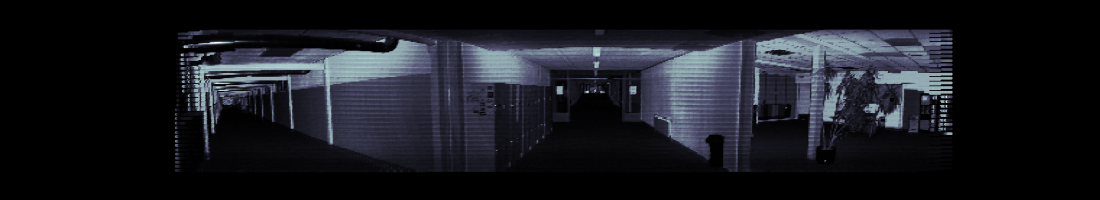

In [8]:
directory = "ruta a archivo individual (Prueba de visualización de imagen)"

img = Image.open(directory)
img

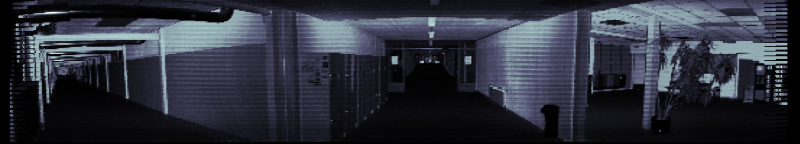

In [28]:
# recortamos la imagen
pixels_from_top = 30
pixels_from_bottom = 26
pixels_from_left = 165
pixels_from_right = 135

# Calculate new boundaries for the crop
new_top_index = pixels_from_top
new_bottom_index = img.size[1] - pixels_from_bottom
new_left_index = pixels_from_left
new_right_index = img.size[0] - pixels_from_right

# Perform the crop
cropped_img = img.crop((new_left_index, new_top_index, new_right_index, new_bottom_index))
cropped_img

In [30]:
source_dir = "ruta a los datos originales"
target_dir = "ruta a los datos procesados"

process_images(source_dir, target_dir, 30, 26, 165, 135)

In [31]:
source_dir = "ruta a los datos con datos reducidos a 64 canales"
target_dir = "ruta a los datos procesados con datos reducidos a 64 canales"

process_images(source_dir, target_dir, 30, 26, 165, 135)

In [32]:
source_dir = "ruta a los datos con datos reducidos a 32 canales"
target_dir = "ruta a los datos procesados con datos reducidos a 32 canales"

process_images(source_dir, target_dir, 30, 26, 165, 135)

In [33]:
source_dir = "ruta a los datos con datos reducidos a 16 canales"
target_dir = "ruta a los datos procesados con datos reducidos a 16 canales"

process_images(source_dir, target_dir, 30, 26, 165, 135)